In [1]:
%load_ext lab_black

In [2]:
import os

os.chdir("../..")

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy_syllables import SpacySyllables
from textstat import syllable_count

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16, 12]

import pyLDAvis.gensim_models
from gensim.corpora.dictionary import Dictionary

pyLDAvis.enable_notebook()
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

import math
import swifter
from functools import reduce

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


# EDA

Autorzy: Dawid Płudowski, Antoni Zajko

In [4]:
df = pd.read_pickle("resources/data/train_data.pkl")
df.head(5)

,doc_id,bow_dict,label
0,8018,"{'afternoon': 1, 'attached': 1, 'board': 1, 'b...",enron
1,126257,"{'accomplished': 1, 'account': 2, 'actor': 6, ...",nytimes
2,278701,"{'able': 1, 'ace': 1, 'advantage': 1, 'adverti...",nytimes
3,97518,"{'able': 1, 'abortion': 5, 'abundance': 1, 'ab...",nytimes
4,157394,"{'according': 1, 'actually': 1, 'address': 1, ...",nytimes


In [5]:
X, y = df["bow_dict"], df["label"]

In [6]:
# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")
nlp.add_pipe("spacytextblob")
nlp.add_pipe("syllables", after="tagger")


class BowDicstWrapper:
    def __init__(self, bow_dicts, labels=None, init_dicts=True):
        self.bow_dicts = bow_dicts
        self.labels = labels

        self.labelwise_wordcount = None
        self.wordcount = None
        self.labelwise_word_frequency = None
        self.word_frequency = None
        self.vocab = None
        self.tokens = None

        if init_dicts:
            self.create_dicts()

    def create_dicts(self):
        if self.labels is not None:
            self._create_all_dicts()
        else:
            self._simple_dicts()

    def _create_vocab(self):
        self.vocab = [x for x in self.wordcount.keys() if type(x) is str]

    def _create_tokens(self):
        self.tokens = list(nlp.pipe(self.vocab))

    def _create_all_dicts(self):

        self.labelwise_wordcount = {
            "enron": {},
            "nytimes": {},
            "nips": {},
            "pubmed": {},
            "kos": {},
        }

        self.labelwise_word_frequency = {
            "enron": {},
            "nytimes": {},
            "nips": {},
            "pubmed": {},
            "kos": {},
        }

        self.wordcount = {}
        self.word_frequency = {}

        for words, label in zip(self.bow_dicts, self.labels):
            for word in words:
                if word in self.labelwise_word_frequency[label]:
                    self.labelwise_word_frequency[label][word] += 1
                    self.labelwise_wordcount[label][word] += words[word]
                else:
                    self.labelwise_word_frequency[label][word] = 1
                    self.labelwise_wordcount[label][word] = words[word]
                if word in self.word_frequency:
                    self.word_frequency[word] += 1
                    self.wordcount[word] += words[word]
                else:
                    self.word_frequency[word] = 1
                    self.wordcount[word] = words[word]

        self._create_vocab()
        self._create_tokens()

    def _simple_dicts(self):
        raise NotImplementedError("guess who didn't implement that method yet lol")

In [7]:
# takes around 1 minute
bow_dicts = BowDicstWrapper(df["bow_dict"], labels=df["label"])

## Śednia długość tekstu 

In [8]:
tmp_df = df.copy()
tmp_df["article_len"] = tmp_df.apply(lambda x: sum(x["bow_dict"].values()), axis=1)

mean_lens = tmp_df.groupby("label")["article_len"].agg("mean")

<AxesSubplot:xlabel='label'>

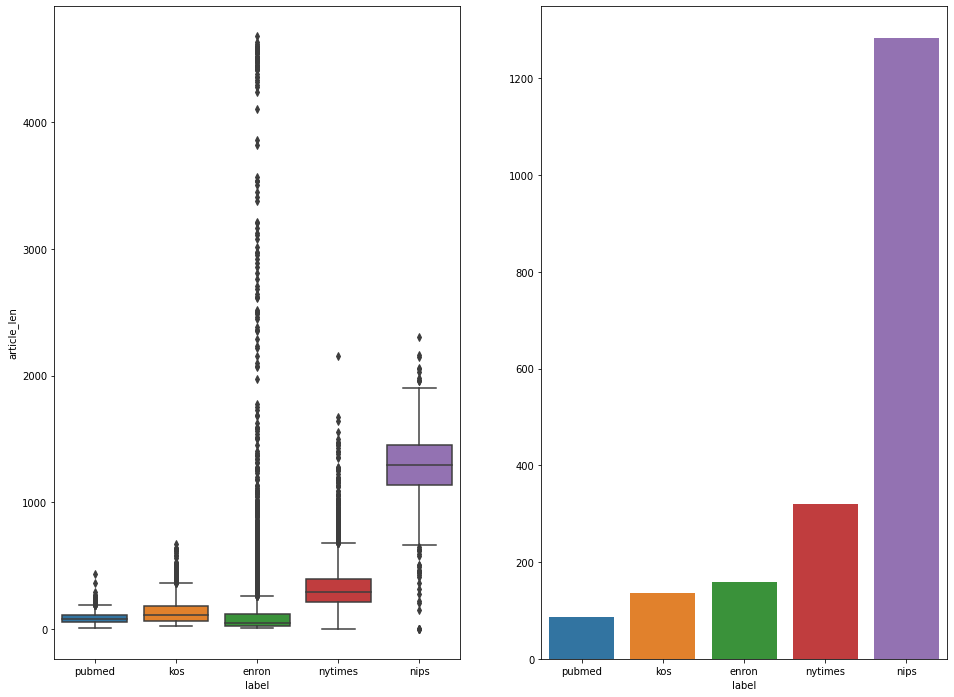

In [9]:
order = ["pubmed", "kos", "enron", "nytimes", "nips"]

plt.subplot(1, 2, 1)
sns.boxplot(x="label", y="article_len", data=tmp_df, order=order)

plt.subplot(1, 2, 2)
sns.barplot(
    x=mean_lens.index,
    y=mean_lens.values,
    order=order,
)

## Barplot najczęstszych słów

[Text(0.5, 1.0, 'TOP 20 words for all articles')]

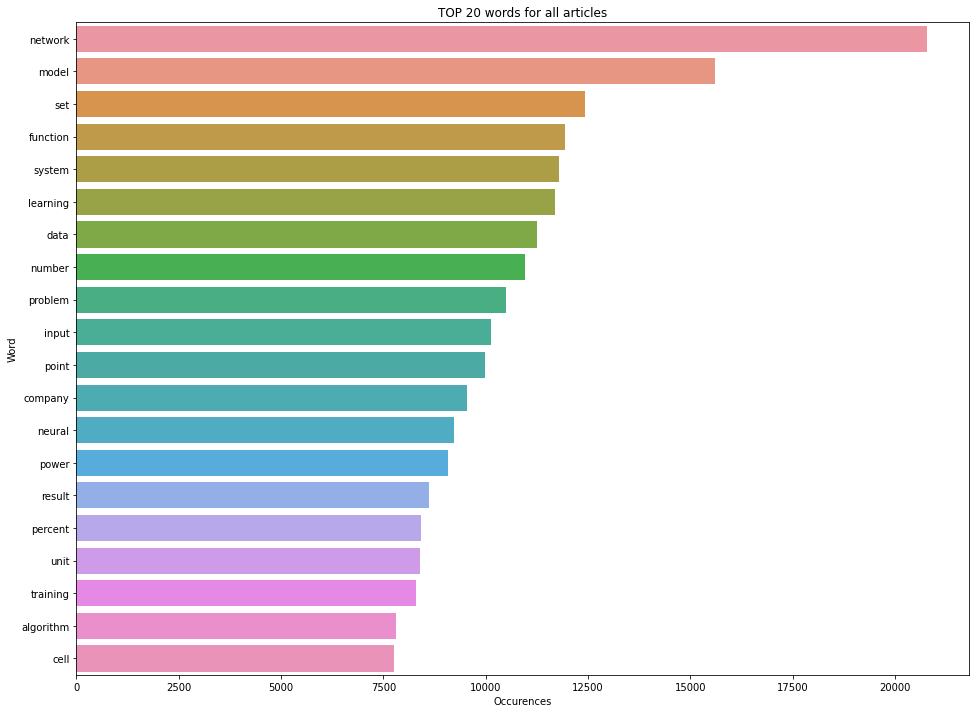

In [10]:
wordcount_tuple = list(bow_dicts.wordcount.items())
wordcount_tuple.sort(key=lambda x: x[1], reverse=True)

tmp_df = pd.DataFrame(wordcount_tuple[:20], columns=["Word", "Occurences"])

sns.barplot(x="Occurences", y="Word", data=tmp_df).set(
    title="TOP 20 words for all articles"
)

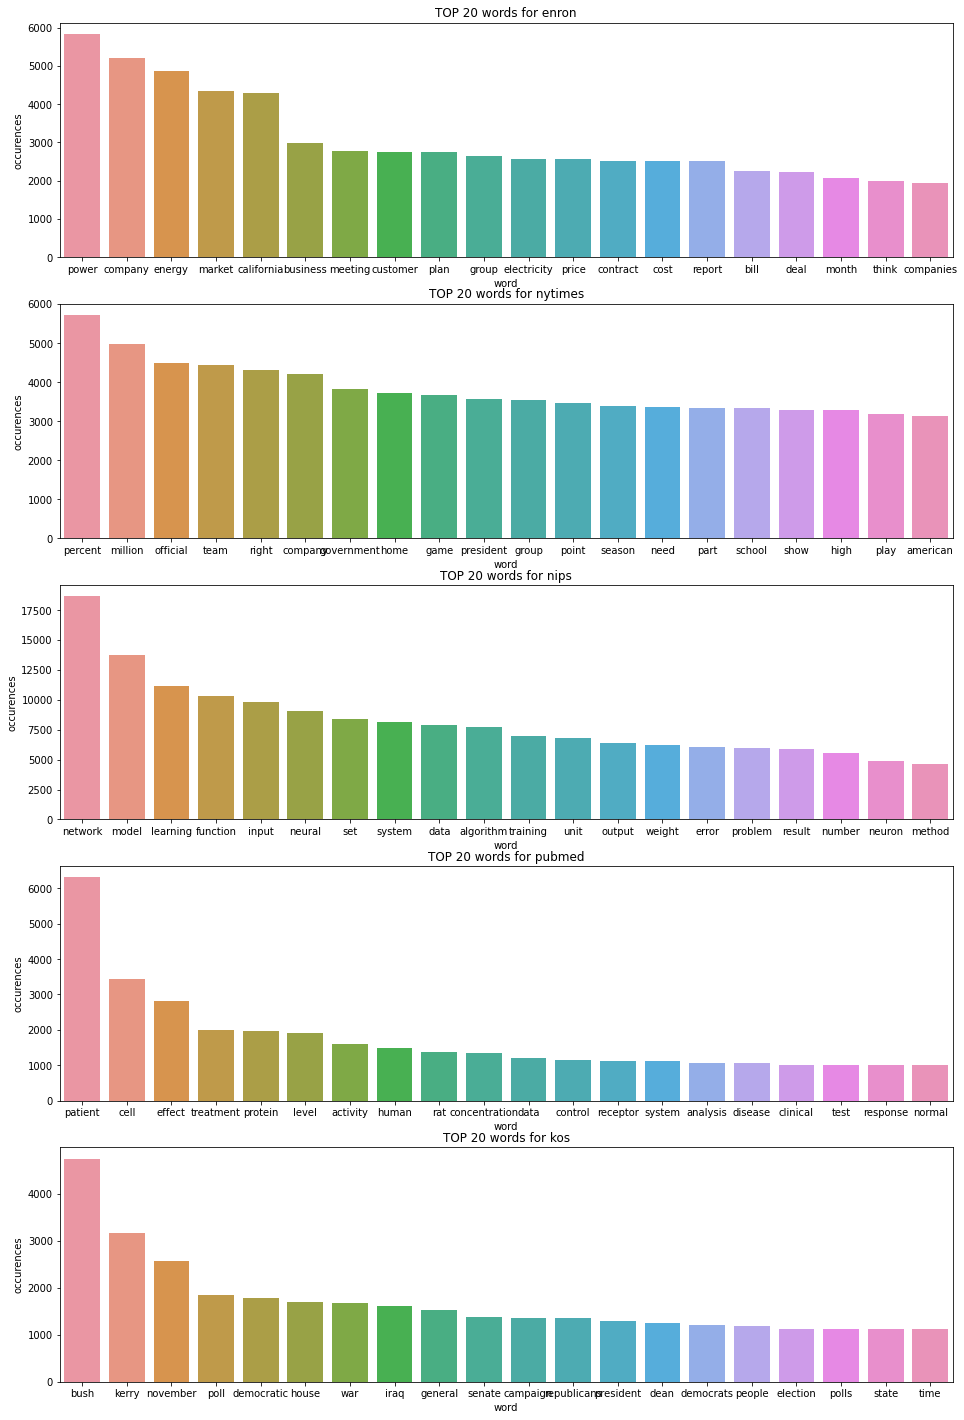

In [11]:
tmp_df = pd.DataFrame(columns=["word", "occurences", "label"])
plt.figure(figsize=(16, 25))

for label in bow_dicts.labelwise_wordcount:
    new_df = pd.DataFrame(
        data=(bow_dicts.labelwise_wordcount[label].items()),
        columns=["word", "occurences"],
    )
    new_df["label"] = label
    tmp_df = pd.concat([tmp_df, new_df], axis=0)

for index, label in enumerate(bow_dicts.labelwise_wordcount):
    plt.subplot(5, 1, index + 1)
    ddf = (
        tmp_df.loc[tmp_df["label"] == label]
        .sort_values(by="occurences", ascending=False)
        .head(20)
    )
    sns.barplot(x="word", y="occurences", data=ddf).set(
        title=f"TOP 20 words for {label}"
    )

## Histogram wystąpień słów

<AxesSubplot:xlabel='Occurences', ylabel='Count'>

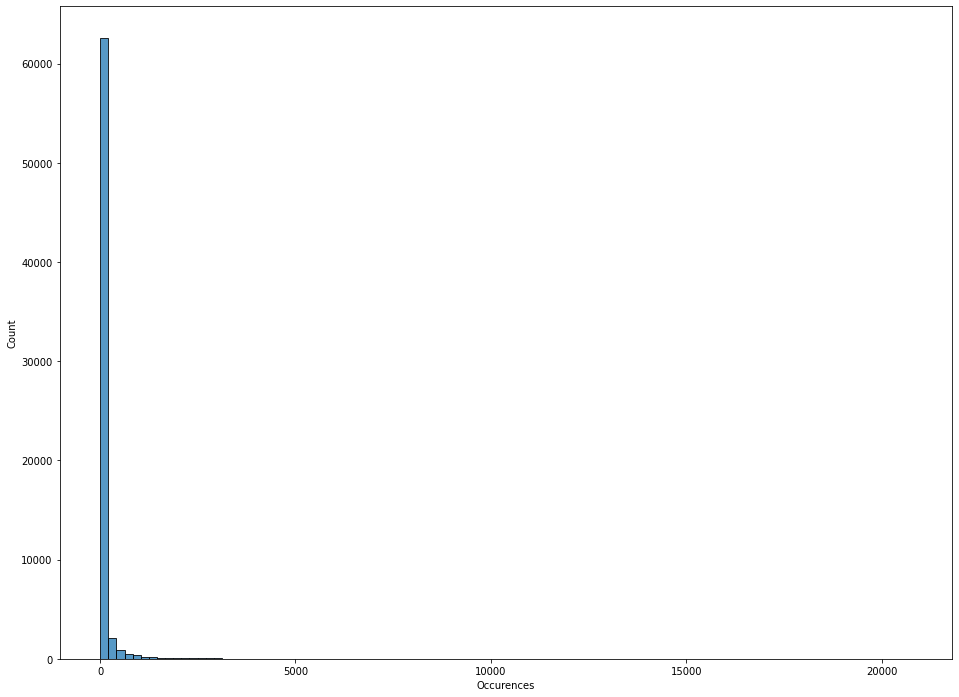

In [12]:
df_words = pd.DataFrame(
    list(bow_dicts.wordcount.items()), columns=["Word", "Occurences"]
)

sns.histplot(x="Occurences", data=df_words, bins=100)

<AxesSubplot:xlabel='Occurences', ylabel='Count'>

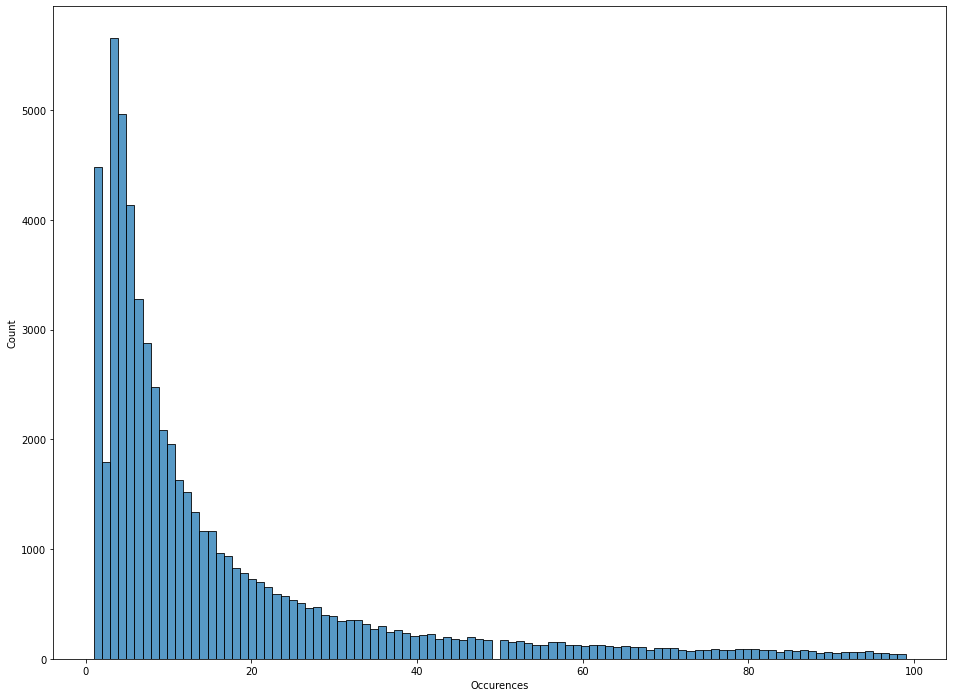

In [13]:
# tylko dla małych liczności

sns.histplot(x="Occurences", data=df_words.loc[df_words["Occurences"] < 100], bins=100)

## Worldcloud bez podziału na labele 

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:513: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 ins

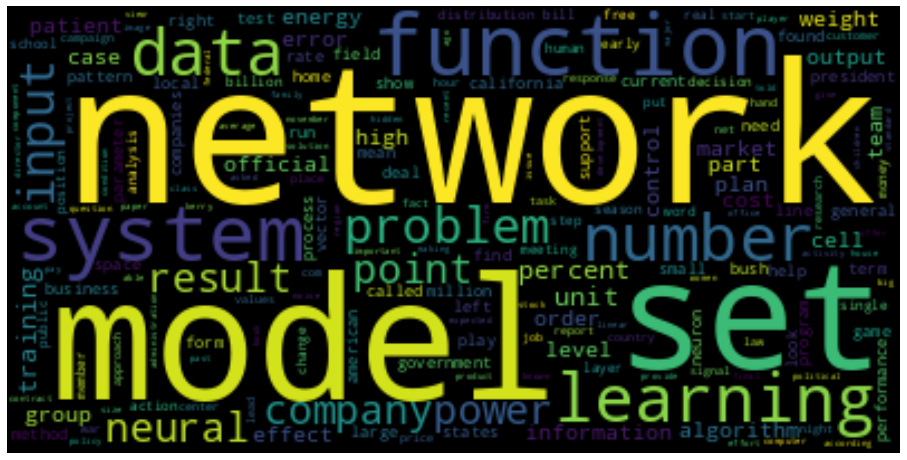

In [14]:
wc = WordCloud()
wc.generate_from_frequencies(bow_dicts.wordcount)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01)

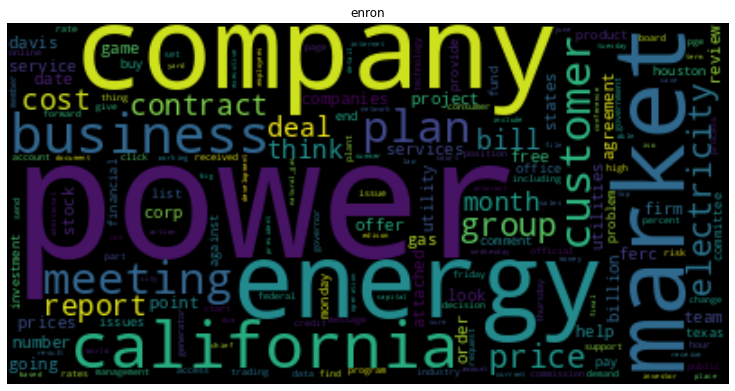

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01)

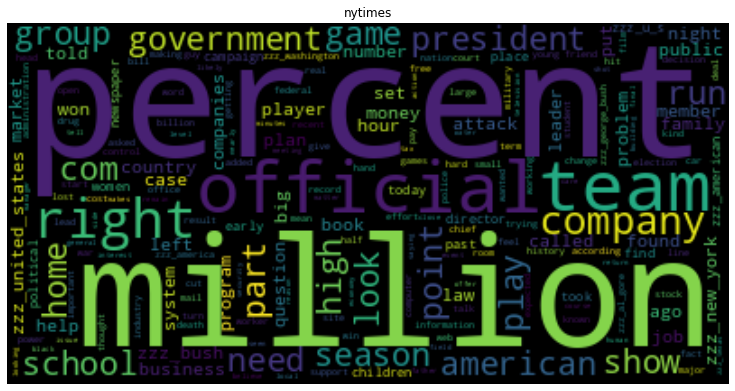

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01)

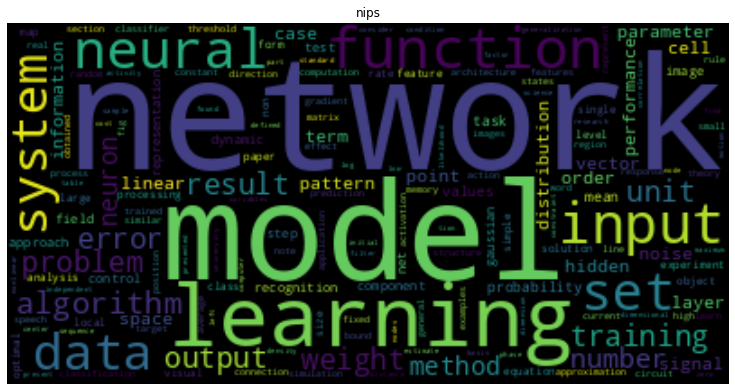

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:513: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/hom

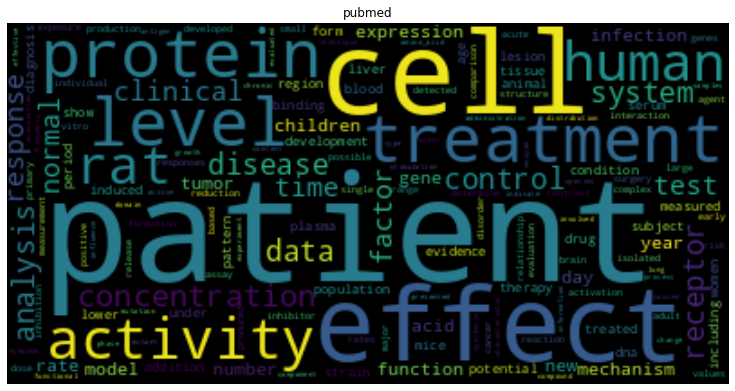

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01)

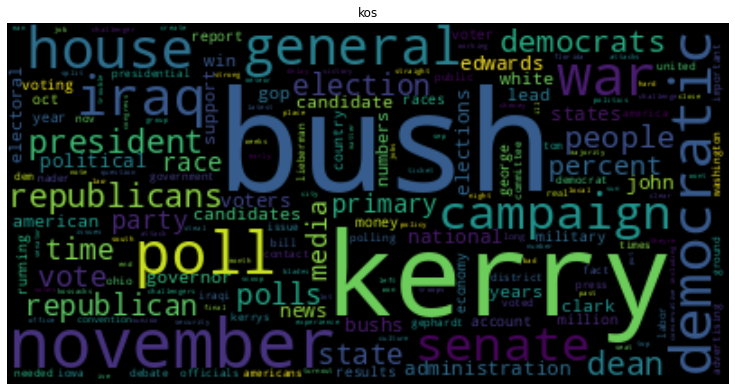

In [15]:
for index, label in enumerate(bow_dicts.labelwise_wordcount):
    wc = WordCloud(width=400, height=200)
    wc.generate_from_frequencies(bow_dicts.labelwise_wordcount[label])
    plt.figure(figsize=(75, 10))
    plt.subplot(1, 5, index + 1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(label)
    plt.show()

## Histogram occurence frequency

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

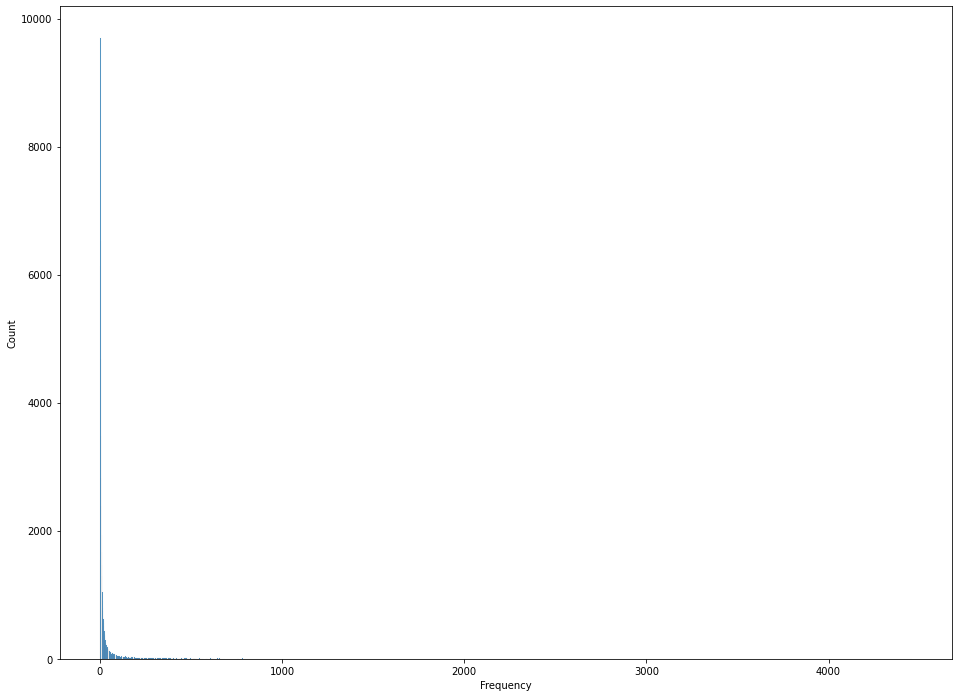

In [16]:
df_words = pd.DataFrame(
    list(bow_dicts.word_frequency.items()), columns=["Word", "Frequency"]
)

sns.histplot(x="Frequency", data=df_words)

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

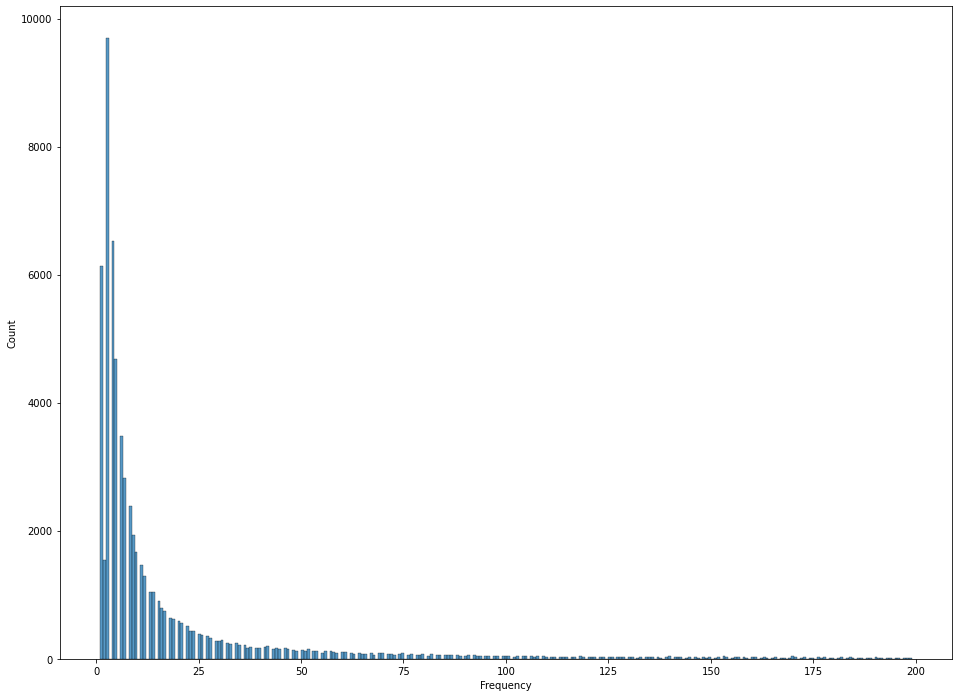

In [17]:
sns.histplot(x="Frequency", data=df_words.loc[df_words["Frequency"] < 200])

## Histogram długości tokenów

In [18]:
lens = list(map(lambda x: len(x), bow_dicts.vocab))

<AxesSubplot:ylabel='Frequency'>

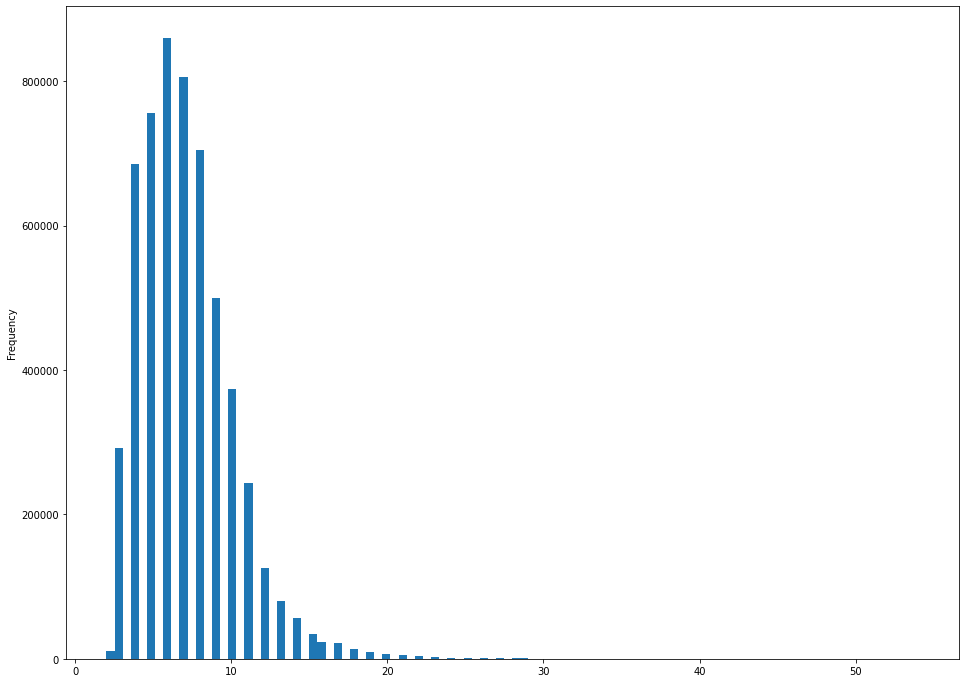

In [19]:
df_words = pd.DataFrame(zip(lens, bow_dicts.vocab), columns=["word_length", "word"])

df_wordcount = pd.DataFrame(
    list(bow_dicts.wordcount.items()), columns=["word", "occurences"]
)

df_merged = df_words.merge(df_wordcount, on="word")
df_merged["sum_len"] = df_merged["word_length"] * df_merged["occurences"]

df_merged["word_length"].plot(kind="hist", weights=df_merged["occurences"], bins=100)

## Sentiment & objectivity 

In [20]:
tmp_df = pd.DataFrame(bow_dicts.tokens)
tmp_df = tmp_df.rename(columns={0: "token"})
tmp_df = tmp_df[["token"]]
tmp_df["word"] = tmp_df["token"].apply(lambda x: x.text)
tmp_df["polarity"] = tmp_df["token"].apply(lambda x: x._.blob.polarity)
tmp_df["subjectivity"] = tmp_df["token"].apply(lambda x: x._.blob.subjectivity)

df_wordcount = pd.DataFrame(
    list(bow_dicts.wordcount.items()), columns=["word", "occurences"]
)

df_merged = tmp_df.merge(df_wordcount, on="word")

<AxesSubplot:ylabel='Frequency'>

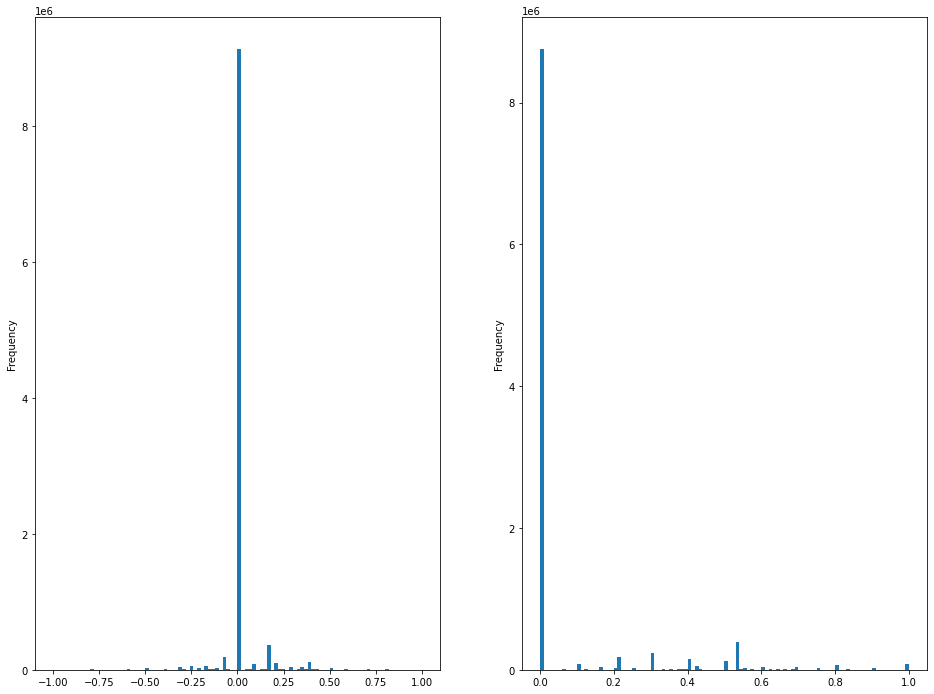

In [21]:
plt.subplot(1, 2, 1)
df_merged["polarity"].plot(kind="hist", weights=df_merged["occurences"], bins=100)

plt.subplot(1, 2, 2)
df_merged["subjectivity"].plot(kind="hist", weights=df_merged["occurences"], bins=100)

<AxesSubplot:ylabel='Frequency'>

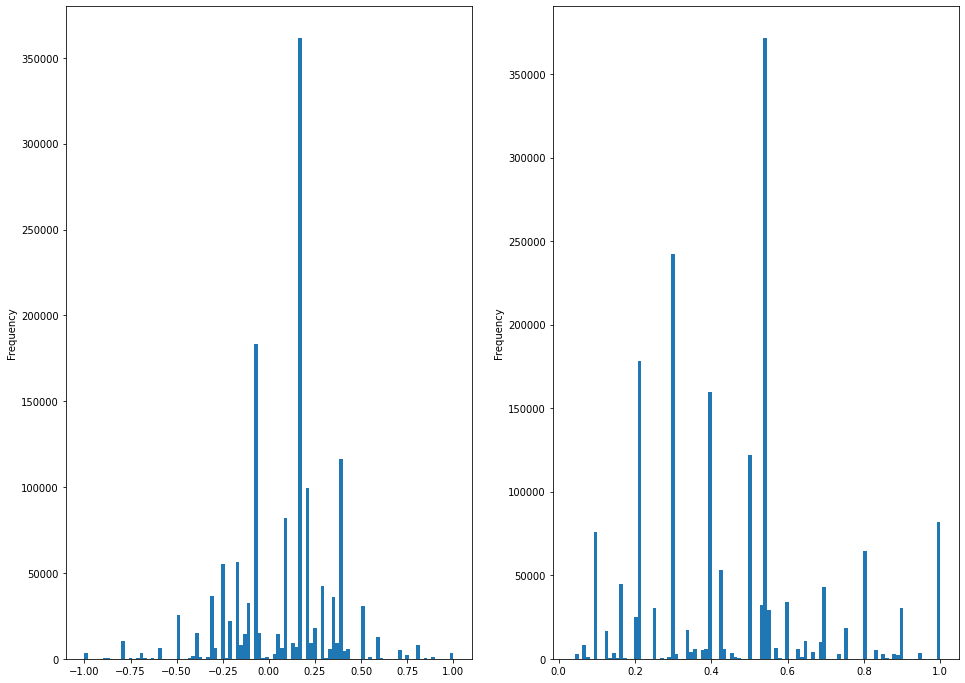

In [22]:
# po usunięciu wartości neutralnych

plt.subplot(1, 2, 1)
df_merged["polarity"].loc[df_merged["polarity"] != 0].plot(
    kind="hist",
    weights=df_merged["occurences"].loc[df_merged["polarity"] != 0],
    bins=100,
)

plt.subplot(1, 2, 2)
df_merged["subjectivity"].loc[df_merged["subjectivity"] != 0].plot(
    kind="hist",
    weights=df_merged["occurences"].loc[df_merged["subjectivity"] != 0],
    bins=100,
)

## Text complexity

In terms of:

$$
score~~=~~\frac{polysyllabels}{N}
$$

where $N$ is total number of words

In [23]:
tmp_df = df.copy()
tmp_df["len"] = tmp_df["bow_dict"].apply(lambda x: sum(x.values()))

In [24]:
def count_pollysylables(old_dict):
    count = 0
    for key in old_dict.keys():
        if type(key) is str and syllable_count(key) > 2:
            count += old_dict[key]
    return count

In [25]:
tmp_df["polysyllabels"] = tmp_df["bow_dict"].apply(count_pollysylables)
tmp_df["smog_frac"] = tmp_df["polysyllabels"] / tmp_df["len"]

<AxesSubplot:xlabel='label', ylabel='smog_frac'>

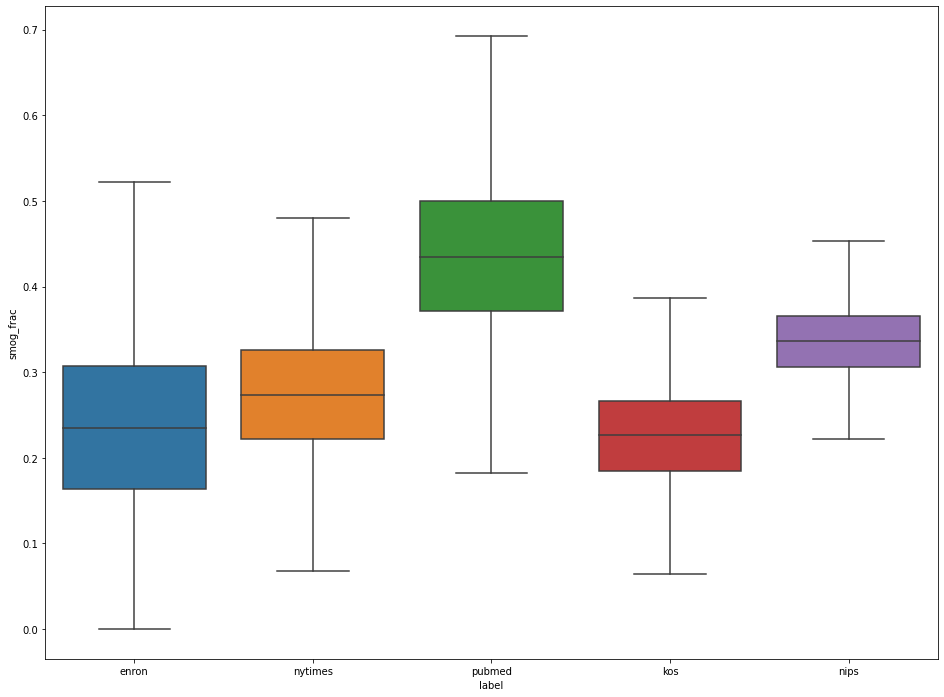

In [26]:
sns.boxplot(y="smog_frac", x="label", data=tmp_df, showfliers=False)

## LDA

In [27]:
def bow_to_list(bow):
    l = [[item[0]] * item[1] for item in bow.items()]
    l = [str(item) for sublist in l for item in sublist]
    return l

In [28]:
token_lists = X.swifter.apply(bow_to_list)

dictionary = Dictionary(token_lists)
bows = token_lists.apply(dictionary.doc2bow)

lda = LdaMulticore(bows, num_topics=4)
vis = pyLDAvis.gensim_models.prepare(lda, bows, dictionary=dictionary)
vis

Pandas Apply:   0%|          | 0/24281 [00:00<?, ?it/s]

/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.008764  0.001561       1        1  35.619621
3     -0.001995 -0.001944       2        1  25.647628
0      0.004604 -0.004804       3        1  20.480978
2      0.006154  0.005186       4        1  18.251773, topic_info=         Term          Freq         Total Category  logprob  loglift
201   network  19561.000000  19561.000000  Default  30.0000  30.0000
1948     data  10785.000000  10785.000000  Default  29.0000  29.0000
2535    model  14916.000000  14916.000000  Default  28.0000  28.0000
1518    input   9417.000000   9417.000000  Default  27.0000  27.0000
767    system  11268.000000  11268.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1047    level   1240.440503   6552.825568   Topic4  -6.7188   0.0365
659      mean   1105.184347   5061.504498   Topic4  -6.8342   0.1793
689     power   1325.400357   9101.113720   Topic4  -6.6525  -0.2258
1141     case   1162.668602   6146.473009   Topic4  -6.7835   0.0357
719    result   1178.044102   8333.340689   Topic4  -6.7704  -0.2555

[389 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
58348      1  0.208219            &quot;i
58348      3  0.624656            &quot;i
58348      4  0.208219            &quot;i
67265      1  0.835720           1,25oh2d
65579      3  0.653821         1-protease
...      ...       ...                ...
58436      4  0.056789  zzz_suntrust_bank
45807      1  0.149752   zzz_tyrone_hayes
45807      2  0.698843   zzz_tyrone_hayes
45807      3  0.049917   zzz_tyrone_hayes
45807      4  0.099835   zzz_tyrone_hayes

[895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

### Scattertext

In [29]:
import scattertext as st

token_lists = X.swifter.apply(bow_to_list)
artificial_texts = X.swifter.apply(lambda l: " ".join([str(el) for el in l]))

Pandas Apply:   0%|          | 0/24281 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24281 [00:00<?, ?it/s]

In [30]:
categories = np.unique(df["label"])

In [31]:
# df['text'] = artificial_texts
# df = df.assign(
#     parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences)
# )
# df.to_pickle("notebooks/resources/df_with_parsed.pkl")
df = pd.read_pickle("notebooks/resources/df_with_parsed.pkl")

print("Create corpus")
corpus = (
    st.CorpusFromParsedDocuments(df, category_col="label", parsed_col="parse")
    .build()
    .get_unigram_corpus()
    .compact(st.AssociationCompactor(2000))
)

for category in categories:
    print(f"Create html for {category}")
    html = st.produce_scattertext_explorer(
        corpus,
        category=category,
        minimum_term_frequency=10,
        pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
    )
    open(f"notebooks/resources/scatter_{category}.html", "w").write(html)

Create corpus


/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/scattertext/termscoring/ScaledFScore.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.zeros(len(cat_scores)).astype(np.float)
/home/antoni/miniconda3/envs/wum/lib/python3.9/site-packages/scattertext/termscoring/ScaledFScore.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

Create html for enron
Create html for kos
Create html for nips
Create html for nytimes
Create html for pubmed


#### enron
![](resources/scatter_enron.png)

#### kos
![](resources/scatter_kos.png)

#### nips
![](resources/scatter_nips.png)

#### nytimes
![](resources/scatter_nytimes.png)

#### pubmed
![](resources/scatter_pubmed.png)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2806cd9-5cf3-4675-a7be-a9a90ed3a708' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>